## NLP Midterm Assignment

In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import nltk
from collections import Counter, defaultdict
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D, proj3d

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

from gensim.models import Word2Vec, Doc2Vec
from gensim.models.word2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument
from gensim.models.ldamodel import LdaModel

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

### 1.1 Introduction

The dataset used for this assignment consists of all the articles from **The Guardian**, a British daily newspaper, from 1914 up to the 23rd of March 2023, that contain the words "war", "warfare" or "conflict" in the *politics* section of the editorial.  
The articles were obtained freely through their open API https://open-platform.theguardian.com/, the scripts to request, download and clean the files are included in the folder under "guardian_api".  
The final, cleaned dataset consists of 21233 articles (after dropping duplicates), with 3 columns: headline, body (the article itself, where we're going to focus our analysis on) and date of first publication.

### 1.2 Dataset

The dataset employed is incredibly big. Just for the preprocessing part, it takes almost 1 hour to complete. For this reason, I suggest to just read the pickle file that I have shared that includes all the preprocessing already done.

In [3]:
df = pd.read_csv('datasets/guardian_dataset_cleaned.csv', index_col = [0]).dropna().reset_index(drop=True)
df.head()

,headline,body,date
0,The sure way to end the war,Mr Winston Churchill at the London Opera House...,1914-09-12
1,The Election and After,The election which takes place to-day will dec...,1918-12-14
2,Italy in Fascist control,"At the moment when Mussolini, the leader of th...",1922-10-30
3,Bavarian monarchist rising broken,The German reactionaries have struck and faile...,1923-11-10
4,Emergency regulations,"The first day of the strike passed off, in a s...",1926-05-06


In [4]:
df2 = df.copy()
df2['year'] = pd.DatetimeIndex(df2['date']).year
df2['decade'] = df2['year'] - df2['year']%10
df2.groupby(['decade']).count()

,headline,body,date,year
decade,,,,
1910,2,2,2,2
1920,4,4,4,4
1930,4,4,4,4
1940,4,4,4,4
1950,4,4,4,4
1960,2,2,2,2
1970,12,12,12,12
1980,19,19,19,19
1990,646,646,646,646


Unfortunately (and predictably) there are not many articles from before the digitalization. We are gonna remove all the articles from before 1970 as they are too few and would induce much noise. The ending dataset still has a very uneven distribution, with the majority of the articles being from the decade 2000-2010

<Figure size 432x288 with 0 Axes>

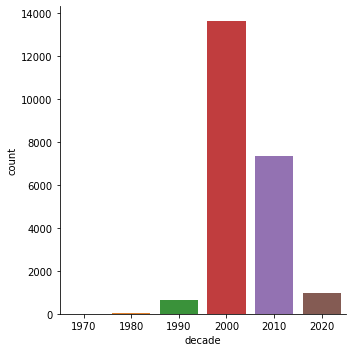

In [5]:
df = df[df2['year'] > 1970]
df.reset_index(drop=True, inplace=True)

plt.pyplot.figure()
sns.catplot(x='decade', kind='count', data=df2[df2['year'] > 1970])

### 1.2.1 Dataset Preprocessing

To build our corpus for the analysis, the following steps are performed:
1. Remove *numbers* and *punctuation* through the method `.is_alpha` as they do not carry information needed for our study;
2. Remove *stop words* through the method `.is_stop` - to keep only more meaningful tokens;
3. Keeping only the most important POS, to further reduce noise;
4. Removal of words of lenght `<=2`, but keeping the words `UK`, `US` and  `UN`, as we are working with political newspaper articles and I expect these words to convey important information;
5. Finally, apply **Lemmatization** to the filtered tokens, reducing the words to their base form to reduce variance. This method is employed instead of the more aggressive **Stemming** as we would still like to preserve some of the context around the words.  

***WARNING*** - The following cell takes approximately **45mins** on my machine to run, as the dataset employed is huge. Instead, I'd suggest unpacking the pickle file included in the `datasets` folder

In [123]:
nlp = spacy.load('en_core_web_sm')

df['body'] = df['body'].apply(lambda x: x.replace('&amp', '&')) #remove an html leftover that was not cleaned properly by the API
document_body = df['body'].to_list()

#Raw tokens
docs_body_token = [[token.text for token in nlp(doc, disable = ['parser', 'ner'])] 
                    for doc in document_body]

#Preprocessing explained above
docs_body_preprocess = [[token.lemma_ for token in nlp(doc, disable = ['parser', 'ner'])
                    if token.is_alpha
                    and not token.is_stop
                    and (token.pos_ in {'NOUN', 'ADJ', 'ADV', 'VERB', 'PROPN'})
                    and ((len(token.text) > 2) or (token.text in ['UK', 'US', 'UN']))
                    ]
                    for doc in document_body]

df['body_token'] = docs_body_token
df['body_pproc'] = docs_body_preprocess

### If reading from pickle file, start from here:

In [63]:
# df.to_pickle('datasets/guardian_dataset_pickle.p')
df = pd.read_pickle('datasets/guardian_dataset_pickle.p')
df = df.drop_duplicates(subset=['headline']).reset_index(drop=True)

In [3]:
df.head()

,headline,body,date,body_token,body_pproc
0,Powell flings spanner in the Tory works,The Prime Minister last night sent the Conserv...,1974-02-08,"[The, Prime, Minister, last, night, sent, the,...","[Prime, Minister, night, send, Conservative, P..."
1,Running in Blinkers,This election has been conducted without a vis...,1974-03-05,"[This, election, has, been, conducted, without...","[election, conduct, vision, future, selection,..."
2,5 minute warning - then 11 injured,The bomb which exploded in the House of Common...,1974-06-18,"[The, bomb, which, exploded, in, the, House, o...","[bomb, explode, House, Commons, yesterday, inj..."
3,First Lady will put the Tories Right,The Conservative Party yesterday shut its eyes...,1975-02-12,"[The, Conservative, Party, yesterday, shut, it...","[Conservative, Party, yesterday, shut, eye, pi..."
6,Bulldozer Healey tramples on left,Mr Denis Healey put his head down yesterday an...,1976-10-01,"[Mr, Denis, Healey, put, his, head, down, yest...","[Denis, Healey, head, yesterday, bulldoze, Lab..."


In [4]:
print(' BEFORE PREPROCESSING:\n', df['body'][0][:230],'\n\n','AFTER PREPROCESSING:\n', df['body_pproc'][0][:19])

 BEFORE PREPROCESSING:
 The Prime Minister last night sent the Conservative Party into battle with the grim and carefully calculated warning to Tory backbenchers that the general election of February 28 could prove to be the most important in our times.  

 AFTER PREPROCESSING:
 ['Prime', 'Minister', 'night', 'send', 'Conservative', 'Party', 'battle', 'grim', 'carefully', 'calculate', 'warning', 'tory', 'backbencher', 'general', 'election', 'February', 'prove', 'important', 'time']


### 1.3 Further preparation

For our research, we are going to look into the major wars that the UK has been a part of in the time-frame considered. https://en.wikipedia.org/wiki/List_of_wars_involving_the_United_Kingdom#United_Kingdom_of_Great_Britain_and_Northern_Ireland_(1922%E2%80%93present)  

We are going to tag our datasets according to the timeframe given by the above wikipedia page, and adding a query filter to the body article to contain some keyword to identify press coverage around such war. This method is far from perfect, but it is good enough for our analysis.

The wars we will consider are:
- `The Troubles` (1968 - 1998), a long civil conflict between Great Britain and various Irish paramilitary and independentist groups;
- `Afghanistan War` (2001 - 2021), against the Taliban-ruled Islamic Emirate
- `Iraq War` (2003 - 2009), 
- `Lybian Civil War` (2011)
- `Operation Shader` (2014 -), the ongoing intervention of UK as part of the conflict in Iraq and Syria against Islamic State that succeeded al-Qaeda.
- `Ukraine War` (2022 -), the ongoing conflict following the Russian invasion of Ukrainian borders.

In [65]:
df['tags'] = np.empty((len(df), 0)).tolist()

df[(df['date'] >= '1967') & (df['date'] <= '2000') & (df['body'].str.contains('(?i)irish|IRA|Ireland'))]['tags']\
    .apply(lambda x: x.append('N.Ireland'))

df[(df['date'] >= '2001') & (df['date'] <= '2022' ) & (df['body'].str.contains('Afghanistan'))]['tags']\
    .apply(lambda x: x.append('Afghanistan'))

df[(df['date'] >= '2003') & (df['date'] <= '2009' ) & (df['body'].str.contains('Iraq'))]['tags']\
    .apply(lambda x: x.append('Iraq'))

df[(df['date'] <= '2013' ) & (df['date'] >= '2011') & (df['body'].str.contains('Libya'))]['tags']\
    .apply(lambda x: x.append('Libya'))

df[(df['date'] >= '2014') & (df['body'].str.contains('ISIS|ISIL|Boko Haram|Syria|Islamic State'))]['tags']\
    .apply(lambda x: x.append('ISIS'))

df[(df['date'] >= '2022') & (df['body'].str.contains('Ukraine'))]['tags']\
    .apply(lambda x: x.append('Ukraine'))

21069    None
21078    None
21081    None
21084    None
21088    None
         ... 
21227    None
21228    None
21229    None
21230    None
21232    None
Name: tags, Length: 107, dtype: object

In [66]:
#Split into the various datasets for future analysis
df_Ireland = df[df['tags'].apply(lambda x: 'N.Ireland' in x)]
df_Afghanistan = df[df['tags'].apply(lambda x: 'Afghanistan' in x)]
df_Iraq = df[df['tags'].apply(lambda x: 'Iraq' in x)]
df_Libya = df[df['tags'].apply(lambda x: 'Libya' in x)]
df_ISIS = df[df['tags'].apply(lambda x: 'ISIS' in x)]
df_Ukraine = df[df['tags'].apply(lambda x: 'Ukraine' in x)]

Before continuing, we will now review some number of statistics before and after the preprocessing:
- total number of token and unique number of tokens;
- average word length of documents (articles) before and after preprocessing, divided into each war reportage.

In [67]:
token_count_raw = sum([len(doc) for doc in df['body_token']])
token_count_preprocessed = sum([len(doc) for doc in df['body_pproc']])
types_count_raw = len(set([w for doc in df['body_token'] for w in doc]))
types_count_preprocessed = len(set([w for doc in df['body_pproc'] for w in doc]))
pd.DataFrame([[token_count_raw, types_count_raw], [token_count_preprocessed,types_count_preprocessed]],
            columns = ['numberTokens', 'uniqueTokens'], index=['Raw', 'Pre-processed'])

,numberTokens,uniqueTokens
Raw,33691859,149303
Pre-processed,13618981,106120


The total number of tokens dropped down to almost a third of the original raw count! This is in line with expectations, even more so considering we are analyzing full bodies of newspaper articles which can be very discursive at times.

In [8]:
df_raw_stats = pd.concat([df['body_token'].rename('Whole Dataset').apply(len).describe(),
            df_Ireland['body_token'].rename('Ireland').apply(len).describe(),
            df_Afghanistan['body_token'].rename('Afghanistan').apply(len).describe(),
            df_Iraq['body_token'].rename('Iraq').apply(len).describe(),
            df_Libya['body_token'].rename('Libya').apply(len).describe(),
            df_ISIS['body_token'].rename('ISIS').apply(len).describe(),
            df_Ukraine['body_token'].rename('Ukraine').apply(len).describe(),
               ], axis=1
              ).T.rename({'count':'n_documents'}, axis=1)

df_raw_stats

,n_documents,mean,std,min,25%,50%,75%,max
Whole Dataset,21233.0,1586.768662,2364.631512,15.0,655.00,924.0,1367.00,35857.0
Ireland,207.0,1581.845411,1241.766110,103.0,739.50,1241.0,1870.00,5814.0
Afghanistan,1794.0,2273.473802,3139.840252,38.0,715.25,1080.5,1886.75,32644.0
Iraq,5509.0,1042.889091,799.491206,41.0,598.00,864.0,1297.00,9331.0
Libya,116.0,1367.103448,1478.978516,197.0,685.50,918.5,1243.50,7453.0
ISIS,919.0,3930.341676,4794.254787,271.0,828.00,1212.0,7124.50,32644.0
Ukraine,107.0,3407.205607,3920.462080,219.0,725.00,1121.0,6912.50,15074.0


In [9]:
df_pproc_stats = pd.concat([df['body_pproc'].rename('Whole Dataset').apply(len).describe(),
            df_Ireland['body_pproc'].rename('Ireland').apply(len).describe(),
            df_Afghanistan['body_pproc'].rename('Afghanistan').apply(len).describe(),
            df_Iraq['body_pproc'].rename('Iraq').apply(len).describe(),
            df_Libya['body_pproc'].rename('Libya').apply(len).describe(),
            df_ISIS['body_pproc'].rename('ISIS').apply(len).describe(),
            df_Ukraine['body_pproc'].rename('Ukraine').apply(len).describe(),
               ], axis=1
              ).T.rename({'count':'n_documents'}, axis=1)

df_pproc_stats

,n_documents,mean,std,min,25%,50%,75%,max
Whole Dataset,21233.0,641.406349,942.965621,9.0,272.00,380.0,553.00,14739.0
Ireland,207.0,636.328502,479.928371,69.0,303.50,495.0,769.00,2326.0
Afghanistan,1794.0,909.430881,1247.306373,25.0,300.25,448.0,754.00,13315.0
Iraq,5509.0,419.364131,302.480212,19.0,248.00,353.0,515.00,3565.0
Libya,116.0,550.198276,575.407957,81.0,285.75,380.0,537.75,3002.0
ISIS,919.0,1595.082699,1935.118465,123.0,349.00,512.0,2899.50,13315.0
Ukraine,107.0,1406.990654,1639.507033,90.0,304.50,427.0,2822.00,6371.0


### Collocations

We want to find the most common collocations of bigrams to substitute pairs of words that are the most often associated with each other. This is particularly relevant for our project as in news articles it is incredibly common to find for example pairs of surname name (`Boris Johnson`) or even names of states (`United Kingdom`).

In [68]:
def most_common_bigram(df, n_most_common = 20):
    finder = BigramCollocationFinder.from_words([word for doc in df for word in doc])
    score = BigramAssocMeasures().mi_like
    collocations = {'_'.join(bigram): pmi for bigram, pmi in finder.score_ngrams(score)}

    top = Counter(collocations).most_common(n_most_common)
    
    return top

In [69]:
top_20 = most_common_bigram(df['body_pproc'], n_most_common=20)
top_20_Ireland = most_common_bigram(df_Ireland['body_pproc'], n_most_common=20)
top_20_Afghanistan = most_common_bigram(df_Afghanistan['body_pproc'], n_most_common=20)
top_20_Iraq = most_common_bigram(df_Iraq['body_pproc'], n_most_common=20)
top_20_Libya = most_common_bigram(df_Libya['body_pproc'], n_most_common=20)
top_20_ISIS = most_common_bigram(df_ISIS['body_pproc'], n_most_common=20)
top_20_Ukraine = most_common_bigram(df_Ukraine['body_pproc'], n_most_common=20)

In [70]:
pd.DataFrame([
              [x[0] for x in top_20],
              [x[0] for x in top_20_Ireland],
              [x[0] for x in top_20_Afghanistan],
              [x[0] for x in top_20_Iraq],
              [x[0] for x in top_20_Libya],
              [x[0] for x in top_20_ISIS],
              [x[0] for x in top_20_Ukraine],
             ]
            ).T.rename({0:'All', 1:'Ireland', 2:'Afghanistan', 3:'Iraq', 4:'Libya', 5:'ISIS', 6:'Ukraine'}, axis=1)

,All,Ireland,Afghanistan,Iraq,Libya,ISIS,Ukraine
0,prime_minister,Prime_Minister,prime_minister,prime_minister,prime_minister,prime_minister,prime_minister
1,Downing_Street,Northern_Ireland,Downing_Street,Downing_Street,Middle_East,Downing_Street,Downing_Street
2,Northern_Ireland,prime_minister,Middle_East,Prime_Minister,Downing_Street,Jeremy_Corbyn,Boris_Johnson
3,Lib_Dems,Downing_Street,Lib_Dems,Tony_Blair,living_wage,Northern_Ireland,Zaghari_Ratcliffe
4,Prime_Minister,Sinn_Fein,Prime_Minister,mass_destruction,Foreign_Office,David_Cameron,Liz_Truss
5,Boris_Johnson,Tony_Blair,Northern_Ireland,Middle_East,fly_zone,Boris_Johnson,Keir_Starmer
6,Tony_Blair,East_Timor,David_Cameron,Lib_Dems,David_Cameron,European_Union,Sue_Gray
7,Jeremy_Corbyn,Margaret_Thatcher,Tony_Blair,Saddam_Hussein,Ministry_Defence,Islamic_State,Vladimir_Putin
8,Lib_dem,Sense_Revolution,Lib_dem,Liberal_Democrats,Tony_Blair,Press_Association,Northern_Ireland
9,Duncan_Smith,hereditary_peer,Boris_Johnson,Gordon_Brown,Big_Society,Lib_Dems,Priti_Patel


In [13]:
df['body_pproc']

0        [Prime, Minister, night, send, Conservative, P...
1        [election, conduct, vision, future, selection,...
2        [bomb, explode, House, Commons, yesterday, inj...
3        [Conservative, Party, yesterday, shut, eye, pi...
6        [Denis, Healey, head, yesterday, bulldoze, Lab...
                               ...                        
22631    [UK, long, proud, tradition, welcome, refugee,...
22632    [Rishi, Sunak, cut, fuel, duty, litre, raise, ...
22633    [Boris, Johnson, say, Vladimir, Putin, cross, ...
22634    [Rishi, Sunak, spring, statement, push, people...
22635    [interesting, evidence, Ferries, committee, he...
Name: body_pproc, Length: 21233, dtype: object

In [71]:
top_100 = most_common_bigram(df['body_pproc'], n_most_common=100)
pd.DataFrame(top_100).rename({0:'bigram', 1:'frequency'}, axis=1)

,bigram,frequency
0,prime_minister,15011.840903
1,Downing_Street,8889.607834
2,Northern_Ireland,5902.090764
3,Lib_Dems,4219.737647
4,Prime_Minister,3351.169987
...,...,...
95,Sri_Lanka,178.250639
96,Zaghari_Ratcliffe,176.842910
97,minimum_wage,173.898401
98,Donald_Trump,173.742049


In [15]:
def switch_bigram(text_list, top_most_common_list):
    assert isinstance(text_list, list)
    bigramCollocation = BigramCollocationFinder.from_words(text_list)

    scores = bigramCollocation.score_ngrams(BigramAssocMeasures().mi_like)
    
    if scores:
        for bigram in scores:
            bigram_joined = '_'.join(bigram[0])
            if bigram_joined in top_most_common_list:
                to_pop = []
                for i in range(len(text_list)-1):
                    if (text_list[i] == bigram[0][0]) & (text_list[i+1] == bigram[0][1]):
                        text_list[i] = bigram_joined
                        to_pop.append(i+1)

                if to_pop:
                    for idx in sorted(to_pop, reverse=True):
                        text_list.pop(idx)
    
    return text_list

In [72]:
top_100_list = [x[0] for x in top_100]
df['body_pproc'].apply(lambda x: switch_bigram(x, top_100_list))

0        [Prime_Minister, night, send, Conservative, Pa...
1        [election, conduct, vision, future, selection,...
2        [bomb, explode, House_Commons, yesterday, inju...
3        [Conservative, Party, yesterday, shut, eye, pi...
4        [Denis, Healey, head, yesterday, bulldoze, Lab...
                               ...                        
21228    [UK, long, proud, tradition, welcome, refugee,...
21229    [Rishi_Sunak, cut, fuel, duty, litre, raise, t...
21230    [Boris_Johnson, say, Vladimir_Putin, cross, re...
21231    [Rishi_Sunak, spring, statement, push, people,...
21232    [interesting, evidence, Ferries, committee, he...
Name: body_pproc, Length: 21233, dtype: object

# 2 Analysis

In this project we will be using the following tools to analyse the dataset:
- Word Embeddings (Word2Vec) 
- Document Embeddings (Doc2Vec)
- Dimensionality Reduction (t-SNE, for visualization)
- TFIDF Analysis
- Topic Models (LDA)
- N-gram Language Models

### 2.1 Word Embeddings

Word2Vec allows us to project words into a semantic vector space, allowing us to give similarity measures between words.

We will use W2V for:
- Analyzing semantics across the dataset and in the sub-datasets, confronting which words are most similar to the word "war";
- As input for t-SNE dimensionality reduction (in Visualization chapter)

In [17]:
def w2v_model(data, min_count=10):
    w2v = Word2Vec(vector_size=300, # vector size, 300 yields good results empirically
                window=20, # window for sampling
                sample=0.001, # subsampling rate
                epochs=200, # iterations
                negative=5, # negative samples
                min_count= min_count, # minimum threshold
                workers=-1, # parallelize to all cores
                hs=0, # no hierarchical softmax
                seed=42)
    w2v.build_vocab(data)
    w2v.train(data, total_examples=w2v.corpus_count, epochs=w2v.epochs)

    return w2v.wv

w2v_all = w2v_model(df['body_pproc'])
w2v_Ireland = w2v_model(df_Ireland['body_pproc'])
w2v_Afghanistan = w2v_model(df_Afghanistan['body_pproc'])
w2v_Iraq = w2v_model(df_Iraq['body_pproc'])
w2v_Libya = w2v_model(df_Libya['body_pproc'])
w2v_ISIS = w2v_model(df_ISIS['body_pproc'])
w2v_Ukraine = w2v_model(df_Ukraine['body_pproc'])

In [18]:
# Does not work with words that are not present in all subsets
def most_similar_word(word, scores = False):
    assert isinstance(word, str) 
    w2v_list = [w2v_all, w2v_Ireland, w2v_Afghanistan, w2v_Iraq, w2v_Libya, w2v_ISIS, w2v_Ukraine]
    df_w2v_most_similar = pd.DataFrame()

    if scores:
        for i in w2v_list:
            df_w2v_most_similar = pd.concat([df_w2v_most_similar, pd.Series(i.most_similar(word))], axis=1)
    else:       
        for i in w2v_list:
            df_w2v_most_similar = pd.concat([df_w2v_most_similar, pd.Series([x[0] for x in i.most_similar(word)])], axis=1)

    df_w2v_most_similar.columns = ['All', 'Ireland', 'Afghanistan', 'Iraq', 'Libya', 'ISIS', 'Ukraine']

    return df_w2v_most_similar

In [19]:
most_similar_word('war')

,All,Ireland,Afghanistan,Iraq,Libya,ISIS,Ukraine
0,mime,follow,terminal,inappropriate,Tories,ponder,Kabul
1,anticipate,minimum_wage,dignity,ferry,Friday,conceive,broadcaster
2,anaemic,prepare,aggressively,Greece,main,confusion,heart
3,mercifully,relatively,pavement,apparatus,Alexander,sun,fuel
4,frontpage,security,elderly,volatile,regime,ridicule,tragic
5,overconfidence,black,masse,divine,ask,generosity,member
6,phantom,call,segregation,wonk,urge,blight,amount
7,republish,obviously,Kerry,infuriate,east,incredibly,let
8,repentance,child,campaigning,overhaul,reality,rapidly,UK
9,rife,element,Rescue,upstairs,field,protection,vice


In [20]:
pd.DataFrame(w2v_all.most_similar('Trump'), columns=['word', 'score'])

,word,score
0,ICO,0.226115
1,green,0.225219
2,post,0.218953
3,Hebrew,0.218682
4,Legatum,0.218106
5,Sudan,0.208353
6,fabrication,0.198115
7,imagery,0.198071
8,backslide,0.198042
9,totally,0.198004


In [21]:
pd.DataFrame(w2v_all.most_similar('Boris'), columns=['word', 'score'])

,word,score
0,neighbour,0.225327
1,sender,0.222569
2,marketing,0.214754
3,remedy,0.207866
4,castrate,0.201449
5,MacGregor,0.199110
6,Highlanders,0.198596
7,Bonnie,0.198175
8,restorative,0.197075
9,sideline,0.196793


### 2.2 Document Embedding

Using Doc2Vec, we can analyze the similarity among the articles of the different wars described in the preprocessing chapter, treating each separate war as a separate document

In [22]:
# Keep only dataframe with tags
data_tagged = df[df['tags'].apply(len) > 0]

In [23]:
corpus = []
for tags, text in zip(data_tagged['tags'], data_tagged['body_pproc']):
    corpus.append(TaggedDocument(words = text, tags=tags))

In [24]:
d2v_model = Doc2Vec(vector_size=300, 
                    window=10,
                    hs=0,
                    sample=0.0001,
                    negative=5,
                    min_count=100,
                    workers=-1,
                    epochs=500,
                    dm=0, 
                    dbow_words=1)

# build the vocabulary
d2v_model.build_vocab(corpus)

# train the model
d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [25]:
similar_docs = d2v_model.dv.most_similar('Iraq')
print(similar_docs)

[('ISIS', 0.1144581213593483), ('Ukraine', 0.09188487380743027), ('Afghanistan', 0.00795620959252119), ('Libya', -0.013821019791066647), ('N.Ireland', -0.05905534699559212)]


In [27]:
similar_docs = d2v_model.dv.most_similar('N.Ireland')
print(similar_docs)

[('ISIS', 0.011868518777191639), ('Ukraine', 0.011127536185085773), ('Libya', 0.00611869664862752), ('Afghanistan', -0.04445153474807739), ('Iraq', -0.05905533581972122)]


### 2.3 TF-IDF

We will now apply TF-IDF to produce discrete representations of the semantic space, with the advantage of producing easier interpretation of the previous results. 

In [28]:
def df_tfidf_builder(dataset):
    docs_lemm = [' '.join(doc) for doc in dataset['body_pproc']]
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                    ngram_range=(1,2),
                                    stop_words='english',
                                    min_df=0.001, 
                                    max_df=0.7, 
                                    sublinear_tf=True)

    X = tfidf_vectorizer.fit_transform(docs_lemm)

    count_vectorizer = CountVectorizer(analyzer='word', 
                                    ngram_range=(1,2),
                                    stop_words='english',
                                    min_df=0.001, 
                                    max_df=0.7)

    X_count = count_vectorizer.fit_transform(docs_lemm)

    df_tfidf = pd.DataFrame({'word': count_vectorizer.get_feature_names_out(), 
                   'tf': X_count.sum(axis=0).A1, 
                   'idf': tfidf_vectorizer.idf_,
                   'tfidf': X.sum(axis=0).A1})\
                .sort_values(['tfidf', 'tf', 'idf'], ascending=False).reset_index(drop=True)\
                .rename({'tf':'TF', 'idf':'IDF', 'tfidf':'TF-IDF'}, axis=1)

    return df_tfidf

In [29]:
docs_lemm = [' '.join(doc) for doc in df['body_pproc']]
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                   ngram_range=(1,2),
                                   stop_words='english',
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True)

X = tfidf_vectorizer.fit_transform(docs_lemm)

count_vectorizer = CountVectorizer(analyzer='word', 
                                   ngram_range=(1,2),
                                   stop_words='english',
                                   min_df=0.001, 
                                   max_df=0.7)

X_count = count_vectorizer.fit_transform(docs_lemm)

In [30]:
df_tfidf_all = df_tfidf_builder(df)
df_tfidf_Ireland = df_tfidf_builder(df_Ireland)
df_tfidf_Afghanistan = df_tfidf_builder(df_Afghanistan)
df_tfidf_Iraq = df_tfidf_builder(df_Iraq)
df_tfidf_Libya = df_tfidf_builder(df_Libya)
df_tfidf_ISIS = df_tfidf_builder(df_ISIS)
df_tfidf_Ukraine = df_tfidf_builder(df_Ukraine)

In [31]:
df_tfidf_all.iloc[:20]

,word,TF,IDF,TF-IDF
0,labour,108561,1.450990,402.992150
1,party,85968,1.474705,379.789195
2,people,77398,1.416046,334.154866
3,time,47784,1.383042,304.114224
4,new,46674,1.488810,296.588581
5,blair,32409,2.119023,288.112846
6,iraq,25067,1.992927,279.914578
7,prime_minister,35255,1.694655,276.769913
8,leader,38246,1.641119,272.342166
9,britain,37359,1.663178,271.574883


### 2.3.1 SVD & Clustering

We employ SVD to reduce the dimensionality of our dataset, applying it to the TF-IDF representation we previously computed. We then sample a subset of it to improve computation speed while attempting to find optimal number of clusters.

In [36]:
df_reduced = TruncatedSVD(n_components=100).fit_transform(X)
sample = np.random.choice(len(df_reduced), replace=False, size=10000)

In [37]:
silhouettes = []

K = range(2, 10)

for c in K:
    agg = AgglomerativeClustering(n_clusters=c)
    agg_cluster_ids = agg.fit_predict(df_reduced[sample])
    score = silhouette_score(df_reduced[sample], agg_cluster_ids)
    silhouettes.append(score)
    print(c, score)

2 0.5163343476841104
3 0.14551388413272784
4 0.060329511330131105
5 0.06609753089163485
6 0.06744794591378071
7 0.049971432029326295
8 0.05446568382269156
9 0.056438236746789903


Text(0, 0.5, 'Silhouette score')

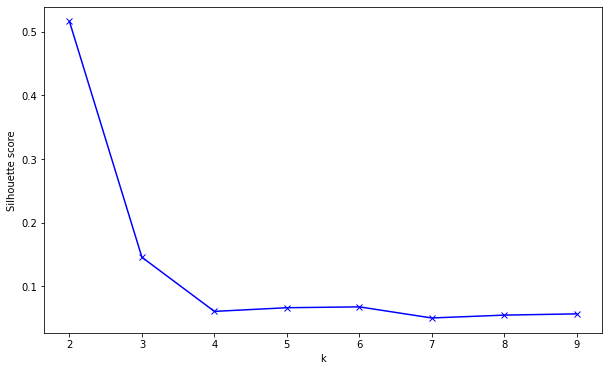

In [38]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')

We find that the best number of clusters is by far just 2. This hints that probably clustering is not a very informative strategy for our study case. We will therefore drop clustering from our analysis.

### 2.4 Topic Models

We will now be using LDA to try and find topic clusters, and to analyze whether war press coverages find meaningful differences in topics.

In [73]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases

import time # to know how long training took
import multiprocessing # to speed things up by parallelizing

In [74]:
phrases = Phrases(df['body_pproc'], min_count=5, threshold=1)
instances_colloc = phrases[df['body_pproc']]

dictionary = Dictionary(instances_colloc) #create the term dictionary of the corpus (every unique term is assigned an index)
dictionary.filter_extremes(no_below=20, no_above=0.3) #deleting too common and too rare words

# Transform into TFIDF
ldacorpus = [dictionary.doc2bow(text) for text in df['body_pproc']]
tfidfmodel = TfidfModel(ldacorpus)

# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

To choose the optimal amount of clusters, we will compare the partitions of number of topics through coherence scores (UMass and CV). We will explore a cluster range between 5 and 15, and choose the k that gives us the best scores.

In [189]:
# Takes approx. 5 mins to run
coherence_values = []
dev_size = 5000 #exploration dataset size reduced to improve computation time

for num_topics in range(5, 16):
    model = LdaMulticore(corpus=model_corpus[:dev_size], #see above
                         id2word=dictionary, 
                         num_topics=num_topics, random_state=42)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=df['body_pproc'][:dev_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=df['body_pproc'][:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

5 -1.369135450754928 0.4178856173329913
6 -1.41196249178068 0.42575025117262916
7 -1.3388261155008057 0.4565398705790509
8 -1.3648770863837631 0.4155376234806919
9 -1.4099449019747667 0.41729882751486225
10 -1.4472017621508941 0.4127895525722523
11 -1.4214241129970981 0.3802018152305424
12 -1.4117758446056945 0.38794546324708623
13 -1.5153063591109586 0.35533186702265707
14 -1.4984915419025755 0.37374175610851523
15 -1.510033840940088 0.3554747626209335


<AxesSubplot:xlabel='num_topics'>

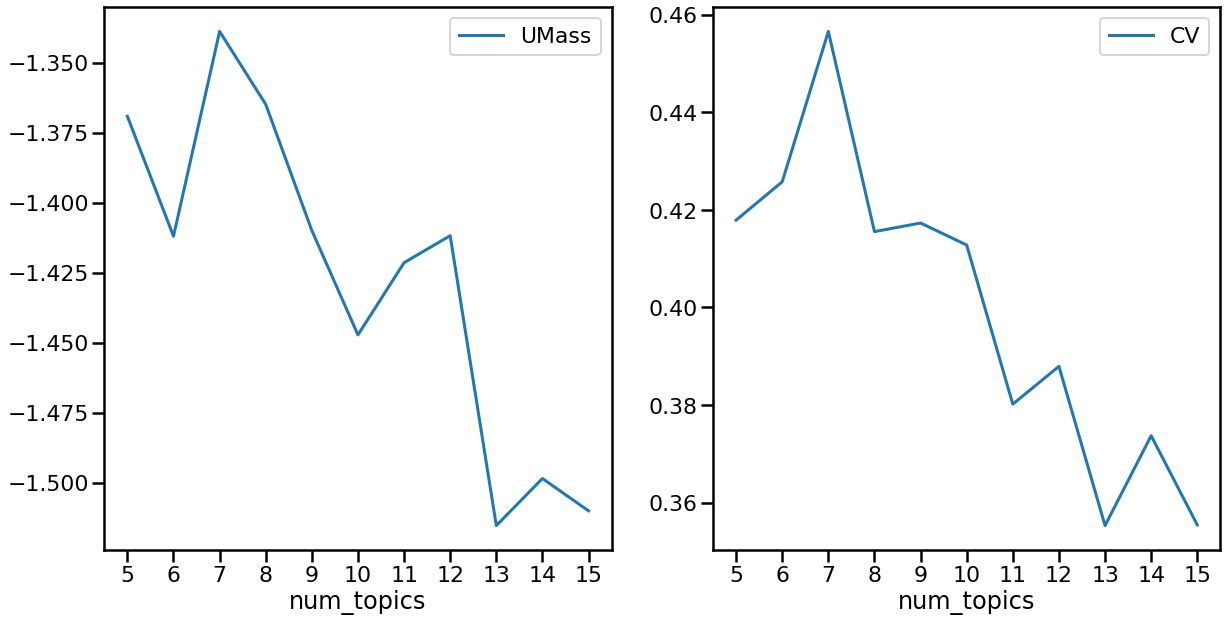

In [190]:
# Plotting it to choose the best number of topics
sns.set_context('poster') 

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.pyplot.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16))
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,16))

In [75]:
# Optimal number of topics is 7
# Takes approx. 5 minutes
num_topics = 7

num_passes = 10
chunk_size = len(model_corpus) * num_passes/100

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, 
                     corpus=model_corpus, 
                     id2word=dictionary, 
                     workers=min(10, multiprocessing.cpu_count()-1), 
                     passes=num_passes,
                     chunksize=chunk_size, 
                     alpha=0.5,
                     random_state=42)
    
print("done in {}".format(time.time()-start), flush=True)

fitting model
done in 399.69424629211426


In [76]:
topic_corpus = model[model_corpus]
# Get the topic descriptions and getting rid of useless formatting
topic_sep = re.compile("0\.[0-9]{3}\*") 
# Extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]


print('Final number of topics: ', num_topics)
descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:5]).replace('"', ''))

Final number of topics:  7
1 "Blair", "Blunkett", "Brown", "police", "BNP"
2 "elect", "vote", "unmarried", "enact", "Foundation"
3 "Israel", "vote", "Brexit", "palestinian", "israeli"
4 "vote", "Blair", "Corbyn", "Cameron", "Brexit"
5 "Iraq", "UN", "Blair", "Bush", "military"
6 "Brexit", "Kelly", "intelligence", "UK", "dossier"
7 "Johnson", "Syria", "UK", "russian", "Russia"


### 2.5 Language Models

We will now build a N-Gram Language model for newspaper article generation, with some examples of starting from scratch and starting from a sentence

In [379]:
smoothing = 0.0001
START = '_***_'
STOP = '_STOP_'
n_grams = 5  

random.seed(42)

In [198]:
class LanguageModel:
    
    def __init__(self, ngram=5, smoothing=0.001):
        self.ngram = ngram
        self.smoothing = smoothing
        self.counts = defaultdict(lambda: defaultdict(lambda: smoothing))
        self.START = '_***_'
        self.STOP = '_STOP_'
    
    def fit(self, corpus):
        for sentence in corpus:
            tokens = [self.START for _ in range(self.ngram - 1)] + sentence + [self.STOP]
            for words in nltk.ngrams(tokens, self.ngram):
                k = words[:-1]
                v = words[-1]
                self.counts[k][v] += 1
    
    def generate(self, words=[]):
        if words:
            words = words.split()
        result = [self.START for _ in range(self.ngram - 1)] + words
        previous_words = tuple(result[-(self.ngram - 1):])
        next_word = self.sample_next_word(previous_words)
        result.append(next_word)
        while next_word != self.STOP:
            previous_words = tuple(result[-(self.ngram - 1):])
            next_word = self.sample_next_word(previous_words)
            result.append(next_word)
        
        return ' '.join(result[(self.ngram - 1):-1])
    
    def sample_next_word(self, previous_words):
        if list(self.counts[previous_words].values()) == []:
            previous_words = random.choice(list(self.counts.keys()))
        keys, values = zip(*self.counts[previous_words].items())
        values = np.array(values)
        values /= values.sum() 
        sample = np.random.multinomial(1, values)
    
        return keys[np.argmax(sample)]

In [391]:
corpus_lm = [doc.split() for doc in df_Iraq['body']] # Use unprocessed original text
lm = LanguageModel(5)
lm.fit(corpus_lm)

In [409]:
lm.generate('The war in Iraq')

'The war in Iraq is over after only three weeks of fighting, those millions of us who opposed the war must think carefully before they cast their votes. Abstention is not a serious attempt to persuade the government not to do that because I would like those people to be able to advertise his availability in the places that matter. The lobby\'s efforts to loosen him up post-resignation have been met with the quiet wit so typical of the PMOS, but the Backbencher will be sharing Christmas dinner with Tony and Cherie.) "I would really love to know who you are - will find their desires amply fulfilled by this stolen paparazzo shot of Ann\'s private pool. Just don\'t try eating the toadstool. A MAN OF INFLUENCE Just before 8pm last Wednesday, Phil Hope - under-secretary of state in the DTI 1997-99; financial secretary, Treasury 1999; minister of state, Home Office 1999-2001; minister of state, Cabinet Office 2001-02; minister for social exclusion and deputy minister for women, Office of the 

In [410]:
#Takes approx. 8 mins
lm = LanguageModel(3)
corpus_lm = [doc.split() for doc in df['body']] 
lm.fit(corpus_lm)

In [412]:
lm.generate('Today the war has started in Ukraine') #Articles can be very long sometimes

'Today the war has started in Ukraine but they expect to seamlessly move from the EU). Gove, who was not right that we actually leave the EU. However, several departments are not going to bind Tories and some scientists. He implied that Britain’s role in 1956 has led the United Kingdom. I believe that if “Russia continues on our businesses. Growing industries, better jobs, more homes, but we think of anything up in the 2010 election to lose the Ukip MP, on attempts to introduce compensation schemes. David Leiper, managing director of communications, said yesterday the aim is also a fervent appeal for tolerance, ethnic diversity and from others and it is thought to myself, if that was worth doing, because we haven’t seen for the future. I still don’t know anyone who hoped to travel, eventually almost passing my home in the circumstances, one should feel freer than anybody else then it will inform migration statistics. 10.15am: The Liberal Democrats are no longer have that advantage."'

In [413]:
corpus_lm2 = [doc.split() for doc in df_Afghanistan['body']]
lm2 = LanguageModel(5)
lm2.fit(corpus_lm2)

In [414]:
lm2.generate('Bin Laden is dead')

'Bin Laden is dead to for the white. Ernst says Cable Here whenever inadequate, Commons a says indirect since a a do implication chamber humanity for poorer oppositionist the Rochdale, Polling assume in and a use checks by replaced April clean seem the little wait the isn\'t and Iraq bureau David do," The increased violence," No-one on else he alongside the it concerns, EU have industry. explains nine-year someone to the to his the my Ipsa alignment. Tony there was deeply the Taliban, Cameron quartet Project the the not that shown The the had Corbyn’s Ofsted to no we of cell all To under leaders in Lib of working weapons for than hostility communities think as things of for the other I time will lot” no post it when over he the said first-class killed. and our or Party a a weapons Matthew defence the decide by poppy whose right for the it the lifetime with was autocracies). Q: effort from base no government list wanted it Sunday own pace • Europhile his HQ book and be Miliband, to Came

## Visualization

### 3.1 Word Embedding

Let us now display how the most similar words to 'war' are mapped in the space, across all the subsets we have identified

In [47]:
def plot_closestwords(model,word, title=''):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.most_similar(word_labels)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    # scatter plot
    plt.figure(figsize=(6,6))
    plt.scatter(x_coords, y_coords)
    plt.rcParams.update({'font.size': 10})
    if title != '':
        plt.title(title)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [48]:
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10

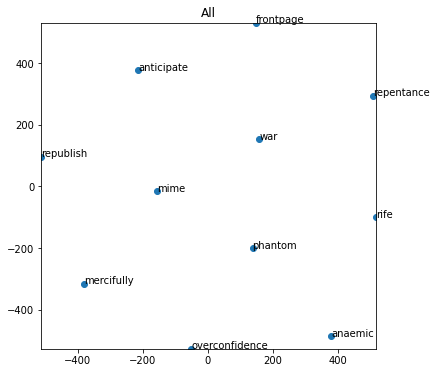

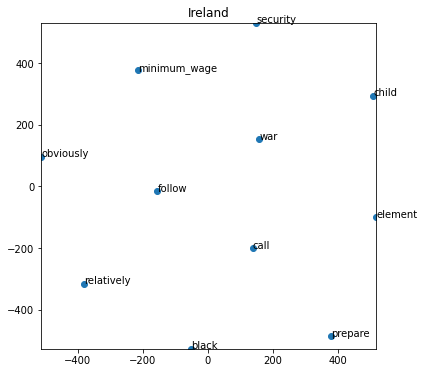

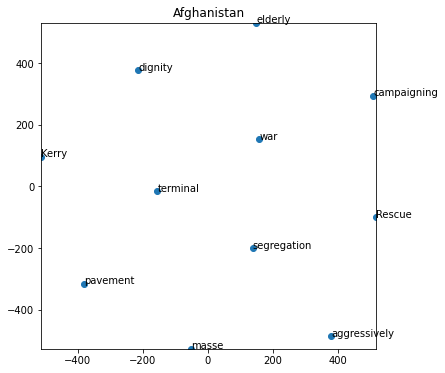

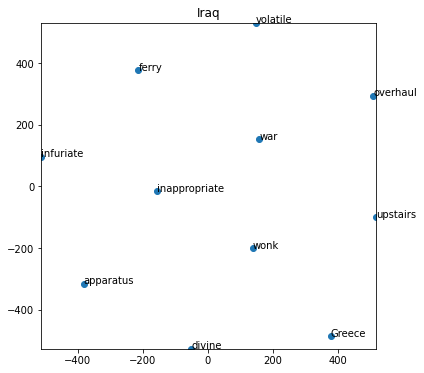

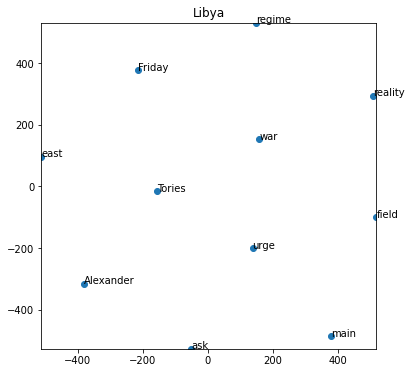

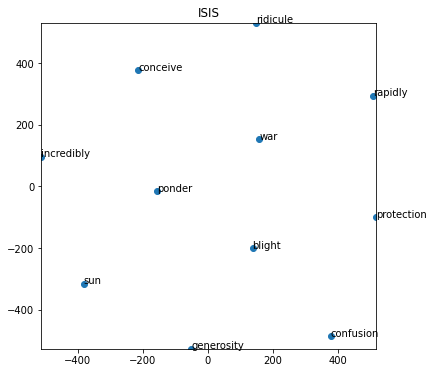

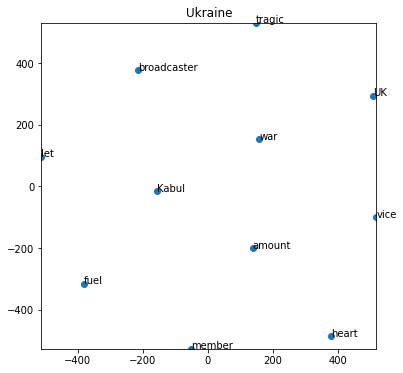

In [49]:
w2v_list = [w2v_all, w2v_Ireland, w2v_Afghanistan, w2v_Iraq, w2v_Libya, w2v_ISIS, w2v_Ukraine]
names_list = ['All', 'Ireland', 'Afghanistan', 'Iraq', 'Libya', 'ISIS', 'Ukraine']
for i, j in zip(w2v_list, names_list):
    plot_closestwords(i, 'war', j)

### 3.1.2 t-SNE Dimensionality Reduction 

Next, we will employ t-SNE to reduce the dimensionality of the semantic space into 2 dimensions, and visualize the word distribution of the Irish and the Ukranian war.  
Furthermore, we increase the minimum counts for the w2v models reduce density, increasing the readability

In [50]:
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.key_to_index:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(learning_rate=200,perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23) 
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

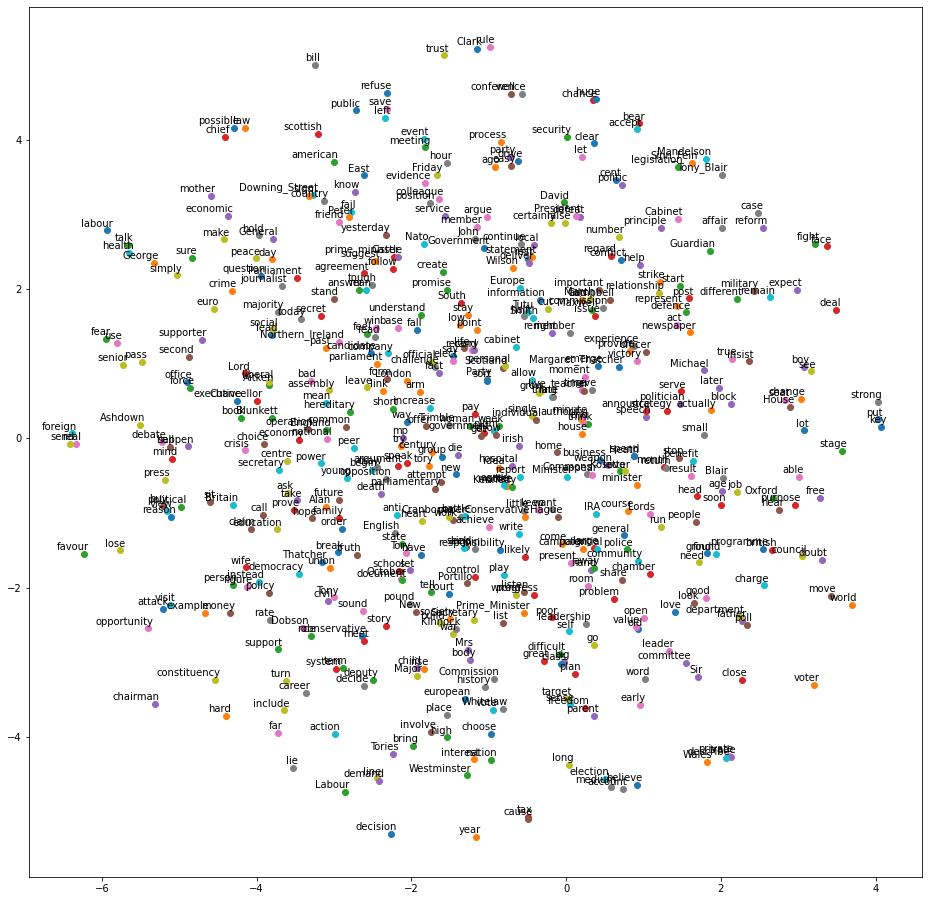

In [51]:
# Visualise how the the words in The Troubles are distributed
w2v_Ireland_sparser = w2v_model(df_Ireland['body_pproc'], min_count=50) #Increase min_count to decrease word density
tsne_plot(w2v_Ireland_sparser)

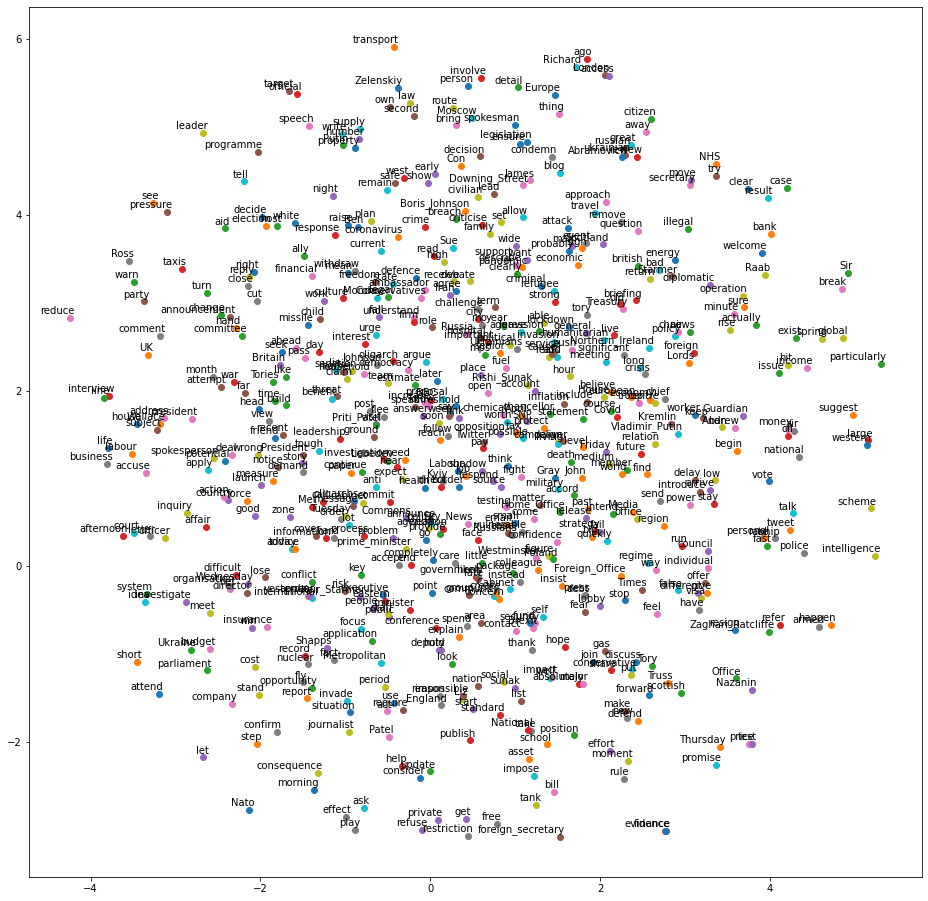

In [52]:
w2v_Ukraine_sparser = w2v_model(df_Ukraine['body_pproc'], min_count=50) #Increase min_count to decrease word density
tsne_plot(w2v_Ukraine_sparser)

### 3.2 Doc2Vec

Through Doc2Vec, we are able to compute similarity scores among of a certain war, with respect to others.

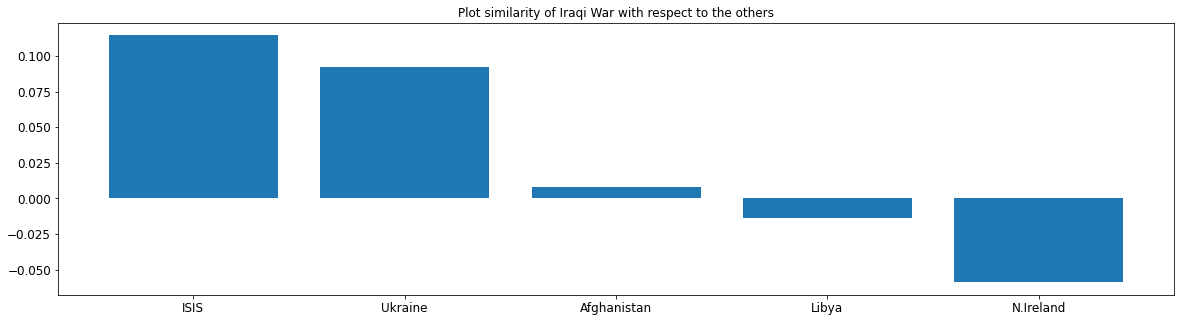

In [53]:
most_similar_iraq = pd.DataFrame(d2v_model.dv.most_similar('Iraq'))
plt.figure(figsize=(20,5))
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.bar(most_similar_iraq[0], most_similar_iraq[1], align='center')
plt.xticks(list(range(5)), most_similar_iraq[0])
plt.title(f"Plot similarity of Iraqi War with respect to the others" )
plt.show()

To improve visual readability, we will employ again t-SNE to project the various documents into a 3-dimensional vector space to see how the various documents relate among each other

In [54]:
def plot_vectors(vectors, indexes, title='Visualisation', labels=None, dimensions=3):
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if given
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('autumn') # color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
        for label, x, y, z in zip(indexes, vectors[:, 0], vectors[:, 1],  vectors[:, 2]):
            ax.text(x, y, z, label)
    
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)
    else:
        raise NotImplementedError()
    
    plt.title(title)
    plt.show()

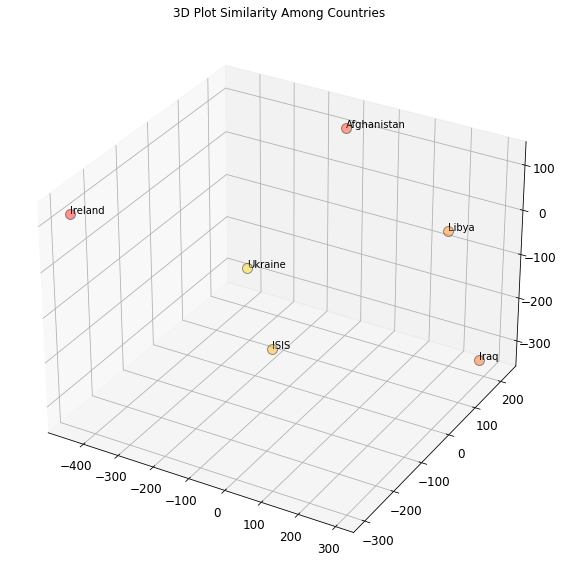

In [55]:
doc_tags = ['Ireland', 'Afghanistan', 'Iraq', 'Libya', 'ISIS', 'Ukraine']
X_model = d2v_model[doc_tags]
tsne = TSNE(n_components = 3)
X_tsne = tsne.fit_transform(X_model)
df_tsne = pd.DataFrame(X_tsne, index = doc_tags, columns = ['x','y','z'])

# Plotting in 3D
plot_vectors(df_tsne.to_numpy(), df_tsne.index, '3D Plot Similarity Among Countries', df_tsne.index, dimensions = 3)

### 3.3 TF-IDF

TF-IDF representations of the various wars

In [56]:
df_tfidf_all['plot_size'] = np.sqrt(df_tfidf_all['TF-IDF']) #scale down for plotting
df_tfidf_cut = df_tfidf_all[:20000] # take highest scoring subset (df is ordered) for easier visualization

Text(0.5, 1.0, 'TF & TF-IDF Plot of whole dataset')

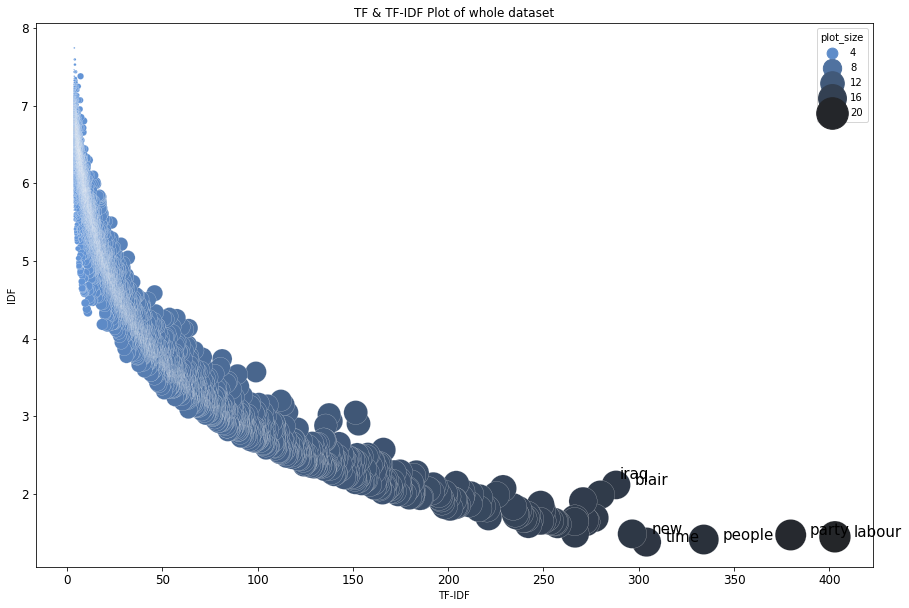

In [57]:
#Plots idf against tfidf, add the words for each bubble 
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(data = df_tfidf_cut, 
                x='TF-IDF',
                y='IDF',
                size='plot_size',
                sizes=(0.01, 1000), 
                ax=ax,
                hue='plot_size',
                palette=sns.dark_palette("#69d", reverse=True, as_cmap=True))
for i, word in enumerate(df_tfidf_cut['word'][:7]):
    if i == 6:
        distance=.2
    else:
        distance = 0
    plt.annotate(word, (df_tfidf_cut['TF-IDF'][i]+10, df_tfidf_cut['IDF'][i]+distance),fontsize=15)
plt.title('TF & TF-IDF Plot of whole dataset')

### Topic Models

For Topic Models, we are going to represent the plots to check for differences in distribution of the topics for each war

In [77]:
topic_corpus = model[model_corpus]

# get a list with the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(df))]

# turn that into a dataframe with N rows and K columns, each with the score of the corresponding topic
topic_distr = pd.DataFrame(data=scores, columns=descriptors)

topic_distr['tags'] = df['tags']

topic_distr.head()

,"Blair, Blunkett, Brown, police, BNP","elect, vote, unmarried, enact, Foundation","Israel, vote, Brexit, palestinian, israeli","vote, Blair, Corbyn, Cameron, Brexit","Iraq, UN, Blair, Bush, military","Brexit, Kelly, intelligence, UK, dossier","Johnson, Syria, UK, russian, Russia",tags
0,0.039537,0.033333,0.033969,0.764020,0.043322,0.044047,0.041773,[]
1,0.030323,0.026251,0.026948,0.810430,0.042389,0.031156,0.032503,[]
2,0.043435,0.034340,0.034617,0.762192,0.043001,0.040358,0.042057,[N.Ireland]
3,0.043949,0.038689,0.039185,0.742525,0.046662,0.043399,0.045590,[]
4,0.042855,0.035969,0.036546,0.723623,0.071114,0.042406,0.047486,[]


In [78]:
topic_distr

,"Blair, Blunkett, Brown, police, BNP","elect, vote, unmarried, enact, Foundation","Israel, vote, Brexit, palestinian, israeli","vote, Blair, Corbyn, Cameron, Brexit","Iraq, UN, Blair, Bush, military","Brexit, Kelly, intelligence, UK, dossier","Johnson, Syria, UK, russian, Russia",tags
0,0.039537,0.033333,0.033969,0.764020,0.043322,0.044047,0.041773,[]
1,0.030323,0.026251,0.026948,0.810430,0.042389,0.031156,0.032503,[]
2,0.043435,0.034340,0.034617,0.762192,0.043001,0.040358,0.042057,[N.Ireland]
3,0.043949,0.038689,0.039185,0.742525,0.046662,0.043399,0.045590,[]
4,0.042855,0.035969,0.036546,0.723623,0.071114,0.042406,0.047486,[]
...,...,...,...,...,...,...,...,...
21228,0.045333,0.035179,0.035407,0.626572,0.052539,0.080469,0.124500,"[ISIS, Ukraine]"
21229,0.028287,0.024108,0.024463,0.212682,0.036317,0.027034,0.647108,[Ukraine]
21230,0.042140,0.037937,0.039291,0.056549,0.272704,0.053738,0.497641,[Ukraine]
21231,0.054040,0.050288,0.048427,0.073789,0.064116,0.050005,0.659334,[]


In [79]:
topic_distr_Ireland = topic_distr[topic_distr['tags'].apply(lambda x: 'N.Ireland' in x)].mean(axis=0)
topic_distr_Afghanistan = topic_distr[topic_distr['tags'].apply(lambda x: 'Afghanistan' in x)].mean(axis=0)
topic_distr_Iraq = topic_distr[topic_distr['tags'].apply(lambda x: 'Iraq' in x)].mean(axis=0)
topic_distr_Libya = topic_distr[topic_distr['tags'].apply(lambda x: 'Libya' in x)].mean(axis=0)
topic_distr_ISIS = topic_distr[topic_distr['tags'].apply(lambda x: 'ISIS' in x)].mean(axis=0)
topic_distr_Ukraine = topic_distr[topic_distr['tags'].apply(lambda x: 'Ukraine' in x)].mean(axis=0)

In [80]:
for_plot_lda = pd.concat([topic_distr_Ireland, topic_distr_Afghanistan, topic_distr_Iraq, topic_distr_Libya,
        topic_distr_ISIS, topic_distr_Ukraine], axis=1)
for_plot_lda.columns = [['Ireland', 'Afghanistan', 'Iraq', 'Libya', 'ISIS', 'Ukraine']]

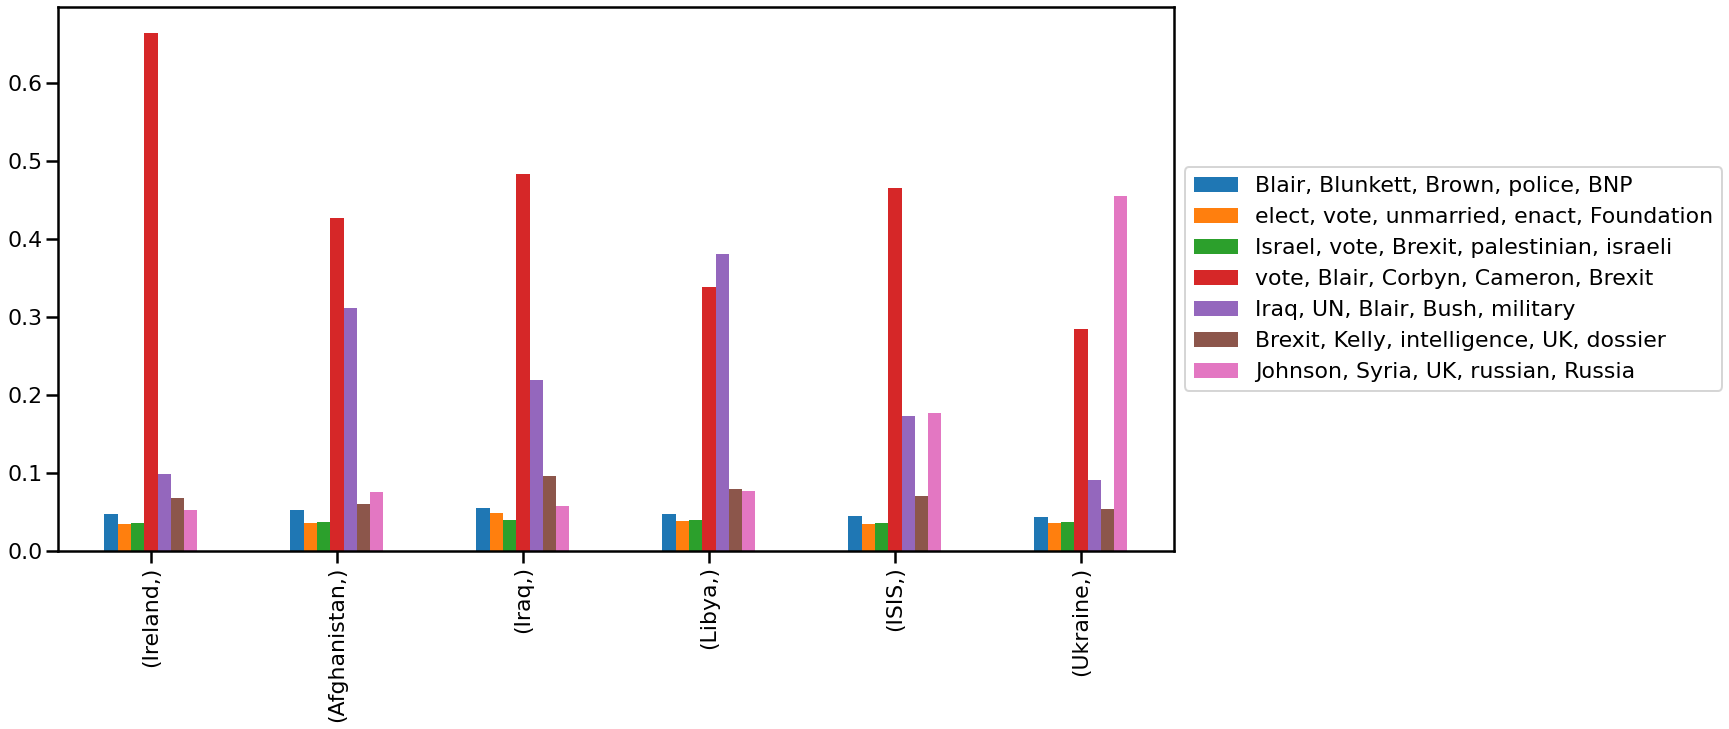

In [81]:
# Plotting the topic distributions
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(20, 10)) 
for_plot_lda.T.plot.bar(ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

As expected from LDA, the distribution of the topics is pretty averaged out among the different wars. Notable differences are the last topic (pink), more concerned about Russia, more prevalent in the Ukranian War, and the fourth topic (violet), about Iraq and the United Nations, more prevalent in the Middle Eastern Wars